In [1]:
import os.path as op

import dill
import matplotlib.pyplot as plt
import mne
import nilearn.plotting as nlplot
import numpy as np
import seaborn as sns
from mne.datasets import eegbci, fetch_fsaverage
from nilearn import surface
from scipy.io import loadmat

sns.set_theme()

cortex = loadmat('anatomy/fs_cortex_20k.mat')
rm = loadmat('anatomy/fs_cortex_20k_region_mapping.mat')['rm']

In [2]:
# Authors: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#          Joan Massich <mailsik@gmail.com>
#          Eric Larson <larson.eric.d@gmail.com>
#
# License: BSD-3-Clause
# Copyright the MNE-Python contributors.

# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)

# The files live in:
subject = "fsaverage"
trans = "fsaverage"  # MNE has a built-in fsaverage transformation
src = op.join(fs_dir, "bem", "fsaverage-ico-5-src.fif")
bem = op.join(fs_dir, "bem", "fsaverage-5120-5120-5120-bem-sol.fif")

0 files missing from root.txt in /home/hareen/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/hareen/mne_data/MNE-fsaverage-data/fsaverage


In [3]:
(raw_fname,) = eegbci.load_data(subject=1, runs=[6])
raw = mne.io.read_raw_edf(raw_fname, preload=True)

# Clean channel names to be able to use a standard 1005 montage
new_names = dict(
    (ch_name, ch_name.rstrip(".").upper().replace("Z", "z").replace("FP", "Fp"))
    for ch_name in raw.ch_names
)
raw.rename_channels(new_names)

# Read and set the EEG electrode locations, which are already in fsaverage's
# space (MNI space) for standard_1020:
montage = mne.channels.make_standard_montage("standard_1005")
raw.set_montage(montage)
raw.set_eeg_reference(projection=True)  # needed for inverse modeling

# Check that the locations of EEG electrodes is correct with respect to MRI
mne.viz.plot_alignment(
    raw.info,
    src=src,
    eeg=["original", "projected"],
    trans=trans,
    show_axes=True,
    mri_fiducials=True,
    dig="fiducials",
)

Extracting EDF parameters from /home/hareen/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Reading /home/hareen/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Using pyvistaqt 3d backend.

Using outer_skin.surf for head surface.
Channel types::	eeg: 64
Projecting sensors to the head surface


In [4]:
fwd = mne.make_forward_solution(
    raw.info, trans=trans, src=src, bem=bem, eeg=True, mindist=5.0, n_jobs=None
)
fwd

Source space          : /home/hareen/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : /home/hareen/micromamba/lib/python3.10/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /home/hareen/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /home/hareen/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  64 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Setting up the BEM model

Good channels,64 EEG
Bad channels,None
Source space,Surface with 20484 vertices
Source orientation,Free


In [5]:
pick_channels = True

if pick_channels:
    data = mne.io.read_raw_edf('epilepsy_27/epilepsy_27_spike_1.edf')
    remapping = {k: k.split(' ')[1].upper().replace("Z", "z").replace("FP", "Fp") for k in data.ch_names}
    data = data.rename_channels(remapping)

    union_ch = list(set(fwd.ch_names) & set(data.ch_names))
    fwd_pick = fwd.copy().pick_channels(union_ch, ordered=True)
    data_pick = data.copy().pick(union_ch)
else:
    fwd_pick = fwd.copy()

fwd_pick['sol']['data'].shape

Extracting EDF parameters from /home/hareen/Projects/bunny/epilepsy_27/epilepsy_27_spike_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


(27, 61452)

In [6]:
region_grouping = np.eye(994)[rm[0]]
fwd_region = fwd_pick['sol']['data'].reshape(len(fwd_pick.ch_names), -1, 3).sum(axis=2) @ region_grouping
fwd_region.shape

(27, 994)

In [7]:
fwd_pick.save(f'leadfield/{fwd_pick["nchan"]}_20k_fwd.fif')

with open(f'leadfield/{fwd_pick["nchan"]}_fwd_region.pkl', 'wb') as f:
    dill.dump(fwd_region, f)

FileExistsError: Destination file exists. Please use option "overwrite=True" to force overwriting.

# additional exps (naive approach)

In [7]:
region_based = False

eeg = data_pick.get_data()
eeg -= np.mean(eeg, axis=0, keepdims=True)
eeg -= np.mean(eeg, axis=1, keepdims=True)
eeg /= np.abs(eeg).max()

if not region_based:
    pred = np.linalg.pinv(fwd_pick['sol']['data']) @ eeg
    pred = pred.reshape(-1, 3, pred.shape[-1]).sum(axis=1)
else:
    pred = np.linalg.pinv(fwd_region, 0) @ eeg

pred

array([[ 2.88781938e-07, -1.95415798e-07, -6.12411382e-07, ...,
        -9.72437277e-07, -9.72437277e-07, -9.72437277e-07],
       [ 4.29903252e-08,  3.79153296e-07,  2.98708338e-07, ...,
         5.04039062e-07,  5.04039062e-07,  5.04039062e-07],
       [ 1.04623952e-07, -1.71510129e-07, -4.25518741e-07, ...,
        -4.37442385e-07, -4.37442385e-07, -4.37442385e-07],
       ...,
       [ 3.35388129e-07,  4.15235504e-07,  4.85427279e-07, ...,
         1.97329652e-07,  1.97329652e-07,  1.97329652e-07],
       [ 3.17617505e-07,  3.97539277e-07,  4.81214444e-07, ...,
         1.82118290e-07,  1.82118290e-07,  1.82118290e-07],
       [ 2.92406018e-07,  3.69817829e-07,  4.64373760e-07, ...,
         1.64299068e-07,  1.64299068e-07,  1.64299068e-07]])

<AxesSubplot:>

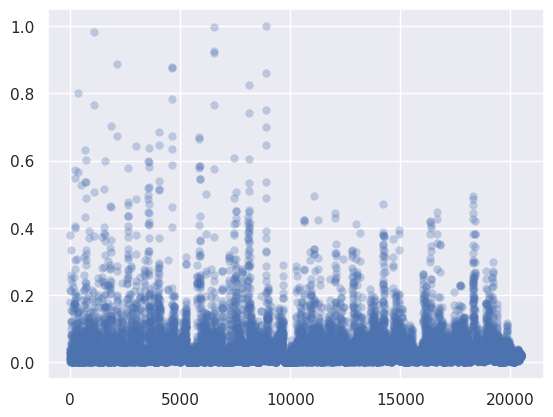

In [8]:
%matplotlib inline

act = (pred ** 2).mean(axis=1)
act /= np.max(act)

sns.scatterplot(act, alpha=0.3, linewidth=0)

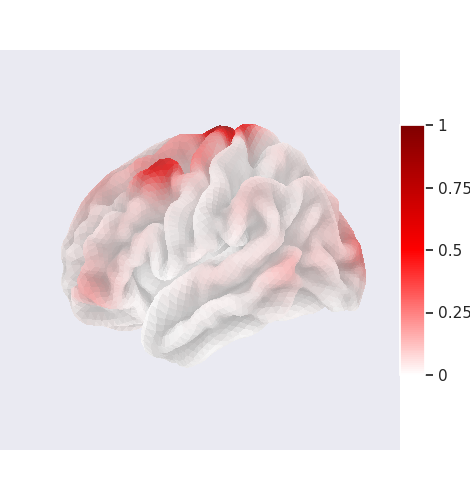

In [9]:
%matplotlib widget

hemi = 'left'
hemi_ind = cortex[f'{hemi}_ind'].flatten() - 1

surf_map = act[rm][:, hemi_ind].flatten() if region_based else act[hemi_ind]
# surf_map /= np.max(surf_map)

surf_mesh = surface.load_surf_mesh(f'anatomy/fsaverage5/surf/{hemi[0]}h.pial')
surf_data = surface.load_surf_data(f'anatomy/fsaverage5/surf/{hemi[0]}h.curv')

nlplot.plot_surf(
    surf_mesh=surf_mesh,
    surf_map=surf_map,
    bg_map=surf_data,
    hemi=hemi,
    colorbar=True,
    bg_on_data=True,
    cmap='seismic',
    vmin=-1,
    vmax=1,
    cbar_vmin=0,
    darkness=1.3,
)

plt.show()